# Data Analysis & Visualization

In this notebook we analyse and visualise the GBIF and IOER monitor data to explore the correlation between Passer domesticus observations and settlement density. The first step is to load and combine the two datasets we downloaded in the previous notebook.

## Load dependencies

In [1]:
import rasterio
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import io
import mapclassify as mc
from rasterio.plot import show
import seaborn as sns

## Define parameters

In [2]:
base_path = Path.cwd().parents[0]
OUTPUT = base_path / "out"

GBIF_SPECIES_OBSERVATIONS = OUTPUT / "occurrences_query.csv"
MONITOR_SETTLEMENT_AREA = OUTPUT / "saxony_S12RG_2023_200m.tif"

CRS_WGS = "EPSG:4326"
CRS_PROJ = "EPSG:3035"

## Prepare methods

Load Saxony boundary

In [3]:
sachsen_proj = gp.read_file(OUTPUT / 'saxony.gpkg')

**Loading Raster Data**
The `load_raster_data()` function opens and returns the raster dataset from the given path. This dataset will be used for sampling raster values later.

In [4]:
def load_raster_data(raster_path):
    """Load raster data and return the raster dataset object."""
    raster = rasterio.open(raster_path)
    return raster

**Loading Species Data**
The `load_species_data()` function loads species observation data from a CSV file and creates a `GeoDataFrame` with latitude and longitude coordinates. The data is given a coordinate reference system (CRS), typically EPSG:4326 (WGS 84).

In [5]:
def load_species_data(csv_path):
    """Load species observation data from CSV and return a GeoDataFrame."""
    df = pd.read_csv(csv_path, low_memory=False)
    geometry = [Point(xy) for xy in zip(df['lng'], df['lat'])]
    gdf = gp.GeoDataFrame(
        df, geometry=geometry, crs=CRS_WGS)
    gdf.to_crs(CRS_PROJ, inplace=True)
    return gdf

**Reprojecting Species Data**
The `reproject_to_raster_crs()` function reprojects the `GeoDataFrame` of species observations to match the CRS of the raster, ensuring that both datasets align spatially.

In [6]:
def reproject_to_raster_crs(gdf, raster_crs):
    """Reproject GeoDataFrame to the CRS of the raster."""
    return gdf.to_crs(raster_crs)

**Sampling Raster Values**
The `sample_raster_at_points()` function retrieves raster values at the locations of the species observation points. It checks if the point is within bounds and handles out-of-bounds points by assigning `np.nan`.

In [7]:
def sample_raster_at_points(raster, points):
    """Sample raster values at given point locations."""
    values = []
    for point in points:
        try:
            row, col = raster.index(point.x, point.y)
            value = raster.read(1)[row, col]
            values.append(value if value != raster.nodata else np.nan)
        except IndexError:
            values.append(np.nan)
    return values

**Correlation Analysis**
The `correlation_analysis()` function computes basic descriptive statistics for settlement density, allowing for a quick overview of the relationship between settlement density and species presence.

In [8]:
def correlation_analysis(species_gdf):
    """Perform simple correlation analysis between settlement density and species presence."""
    clean_data = species_gdf.dropna(subset=['settlement_density'])
    print("Correlation between settlement density and species presence:")
    print(clean_data[['settlement_density']].describe())


## Visualize

**Visualization**
The `plot_raster_obs()` function coordinates the entire process, from loading the raster and species data to reprojecting and sampling raster values at species observation points. It also performs a simple correlation analysis between settlement density and species presence. Finally, it visualizes the results by plotting the raster data with species observations overlaid.

In [9]:
def plot_raster_with_observations(raster, species_gdf):
    """Visualize the raster data and species observations."""
    raster_data = raster.read(1)

    # Manually mask the nodata values
    masked_data = np.ma.masked_equal(raster_data, raster.nodata)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot raster with show() from rasterio
    raster_image = show(
        masked_data,
        transform=raster.transform,
        ax=ax,
        cmap='Reds',
        title="Raster Data with Colorbar"
    )

    # Create a colorbar from the plotted image
    cbar = fig.colorbar(raster_image.get_images()[0], ax=ax, orientation='vertical')
    cbar.set_label('Settlement density')
    # Plot species observations
    species_gdf.plot(
        ax=ax, color='blue', markersize=2, label='Species Observations')
    
    plt.legend()
    plt.title('Species Observations and Settlement Density')
    ax.axis('off')
    plt.show()

In [10]:
def plot_raster_obs(raster_path, csv_path, bound_shape):
    """Load data and visualize the raster with species observations."""
    # Load data sources
    raster = load_raster_data(raster_path)
    species_gdf = load_species_data(csv_path)
    
    clipped_species_gdf = gp.clip(species_gdf, bound_shape).copy()
    clipped_species_gdf['settlement_density'] = sample_raster_at_points(
        raster, clipped_species_gdf.geometry)

    # Perform correlation analysis
    correlation_analysis(clipped_species_gdf)

    # Visualize the raster and species observations
    plot_raster_with_observations(raster, clipped_species_gdf)

Correlation between settlement density and species presence:
       settlement_density
count         9259.000000
mean            49.888243
std             41.492324
min              0.000000
25%              2.603732
50%             49.501995
75%             96.925903
max            100.000000


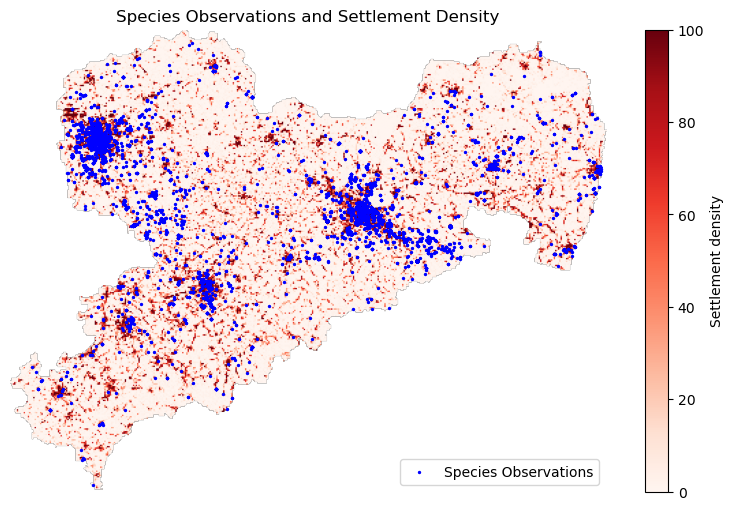

In [11]:
plot_raster_obs(
    MONITOR_SETTLEMENT_AREA,
    GBIF_SPECIES_OBSERVATIONS,
    sachsen_proj)

## Study correlation

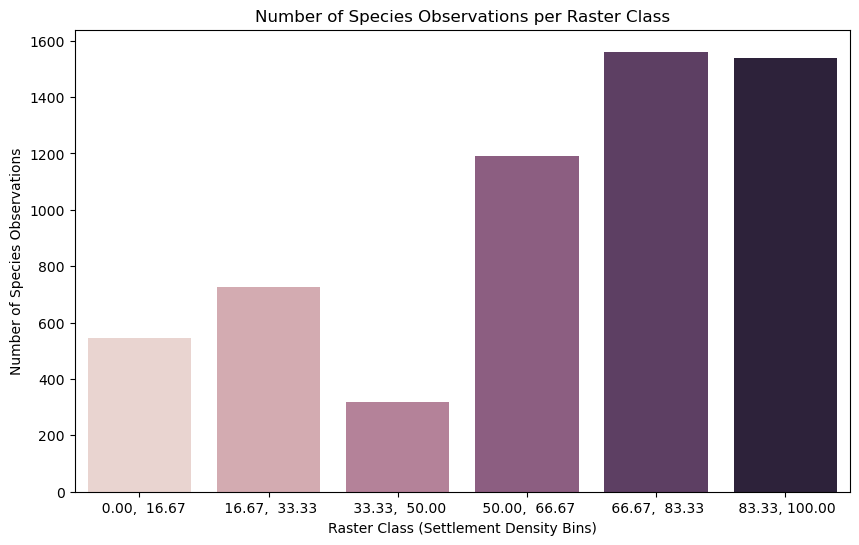

In [16]:
species_gdf = load_species_data(
    GBIF_SPECIES_OBSERVATIONS)
raster = load_raster_data(
    MONITOR_SETTLEMENT_AREA)

clipped_species_gdf = gp.clip(
    species_gdf, sachsen_proj).copy()
clipped_species_gdf['settlement_density'] = sample_raster_at_points(
    raster, clipped_species_gdf.geometry)

# Mask NaN values (exclude invalid species observations directly)
valid_points = clipped_species_gdf.dropna(
    subset=['settlement_density']).copy()

# Use mapclassify for quantile-based classification
classifier = mc.EqualInterval(valid_points['settlement_density'], k=6)
raster_bins = classifier.bins
class_labels = classifier.get_legend_classes(fmt="{:.2f}")

# Remove the brackets and customize the formatting
class_labels = [label.strip("[]()") for label in class_labels]

# Categorize settlement densities
valid_points['raster_class'] = np.digitize(
    valid_points['settlement_density'], raster_bins)

# Group by class and map labels to the classes
class_counts = valid_points['raster_class'].value_counts().reset_index()
class_counts.columns = ['raster_class', 'count']

# Map class labels directly without needing 'N/A' checks
class_counts['raster_bin'] = class_counts['raster_class'].apply(
    lambda x: class_labels[x - 1] if 0 < x <= len(class_labels) else None
)

# Filter out rows with None values in the 'raster_bin' column
class_counts_filtered = class_counts.dropna(subset=['raster_bin'])

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(
    x='raster_bin', y='count', data=class_counts_filtered, 
    hue='raster_class', legend=False, order=class_labels)
plt.xlabel('Raster Class (Settlement Density Bins)')
plt.ylabel('Number of Species Observations')
plt.title('Number of Species Observations per Raster Class')
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare the data for regression
X = np.arange(len(class_counts_filtered)).reshape(-1, 1)  # Settlement class index (0, 1, ..., n-1)
y = class_counts_filtered['count'].values  # Number of species observations

# Fit a simple linear regression
model = LinearRegression()
model.fit(X, y)

# Compute the R² value
r_squared = r2_score(y, model.predict(X))
print(f"R² value: {r_squared:.4f}")

R² value: 0.9623


## Interpretation

An **R² value (coefficient of determination)** of **0.9623** means that **96.2%** of the variance in the **number of species observations** can be explained by the **settlement density**. Here's a breakdown of what this means:

What R² Represents:

- **R²** measures how well the independent variable (in this case, settlement density) explains the variation in the dependent variable (the number of species observations).
- **R² = 1** means a perfect fit, where the independent variable fully explains the dependent variable’s variation.
- **R² = 0** means there’s no explanatory relationship, meaning the independent variable doesn’t help explain the dependent variable at all.

```{admonition} What Does This Mean in Practical Terms?
:class: dropdown, tip

An R² of 0.9623 indicates a very strong positive correlation between settlement density and species observations. While it doesn't explain all the variability, it’s still a significant factor. The remaining 3.77% of the variation might be due to other factors not accounted for in your analysis, like environmental factors, climate, terrain, or other ecological variables, or sampling error.
```

```{admonition} Limitations of R²
:class: dropdown, caution
- **R² doesn’t indicate causality**: While there's a strong relationship, we can't say that settlement density causes species observations. It simply means there's a correlation.
- **Outliers**: Be aware of any outliers, as they can have a disproportionate effect on the R² value. We have a small sample, which can easily be affected by outliers (e.g. a single species observer skewing the results).
- **Linear Assumption**: R² assumes a linear relationship. If the relationship is non-linear, it might not be the best measure.
```

In summary, a **0.9623 R²** suggests that **settlement density** is a very significant factor in explaining species observations for the **Passer domesticus**.